In [127]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [128]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [129]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D 
#from sklearn import datasets
import random
import pickle
import pandas as pd

In [130]:
np.random.seed(0)

In [131]:
with open("german-traffic-signs/train.p", "rb") as f:
  train_data=pickle.load(f)
with open("german-traffic-signs/valid.p", "rb") as f:
  val_data=pickle.load(f)
with open("german-traffic-signs/test.p", "rb") as f:
  test_data=pickle.load(f)

X_train, y_train = train_data["features"], train_data["labels"]
X_val, y_val = val_data["features"], val_data["labels"]
X_test, y_test = test_data["features"], test_data["labels"]




In [132]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [133]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"

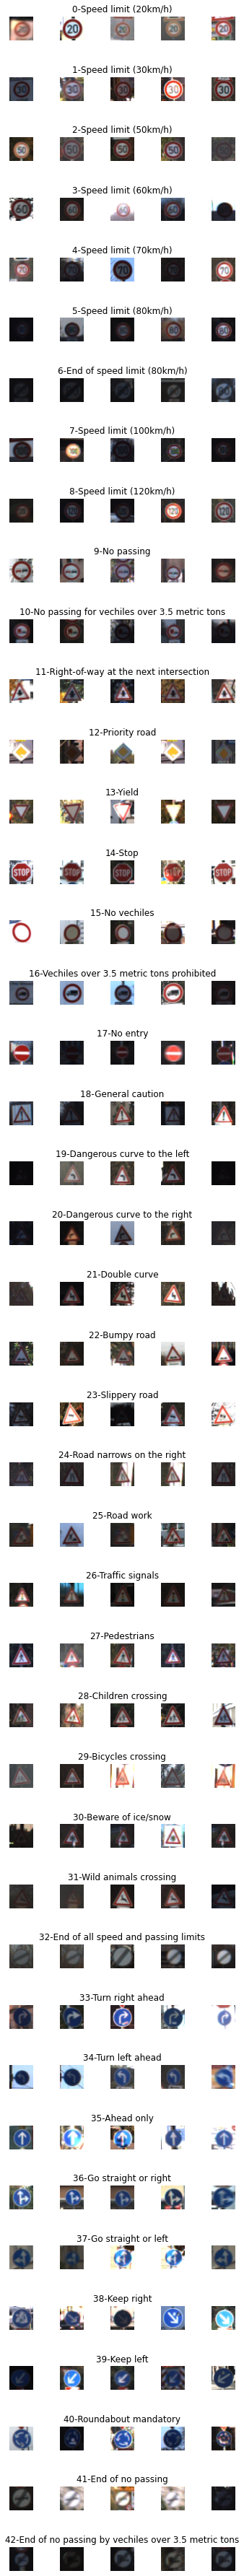

In [134]:
data = pd.read_csv("german-traffic-signs/signnames.csv")

num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5,50))
fig.tight_layout()
for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap("gray"))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + "-" + row["SignName"])
      num_of_samples.append(len(x_selected))


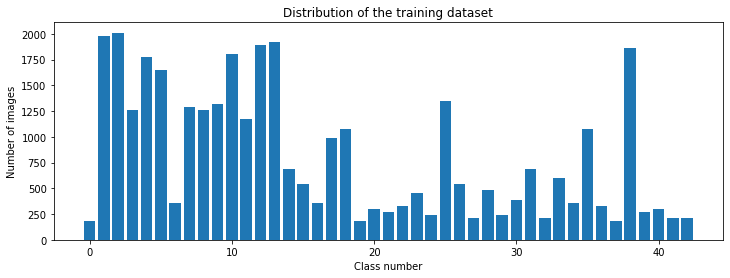

In [135]:
plt.figure(figsize =(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


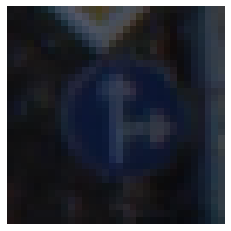

In [136]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


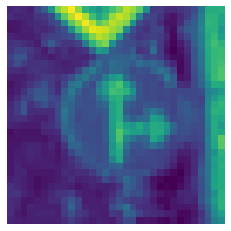

In [137]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(-0.5, 31.5, 31.5, -0.5)

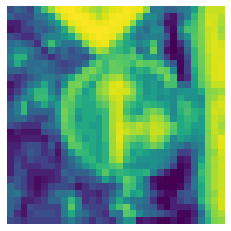

In [138]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")

In [139]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))



(34799, 32, 32)


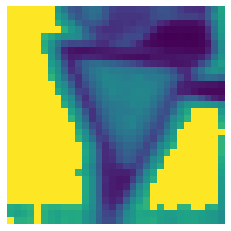

In [140]:
plt.imshow(X_train[random.randint(0,len(X_train) -1)])
plt.axis("off")
print(X_train.shape)

In [141]:
X_train = X_train.reshape(34799, 32,32,1)
X_test = X_test.reshape(12630, 32,32,1)
X_val = X_val.reshape(4410, 32,32,1)

In [142]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
datagen.fit(X_train)

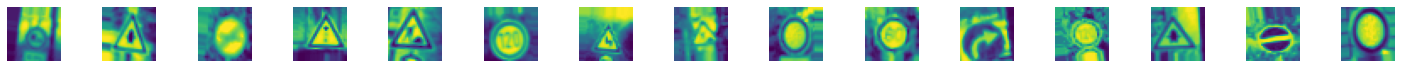

In [143]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)
fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()
for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis("off")

In [144]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [145]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [146]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation="relu"))
  model.add(Conv2D(60, (5,5), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Two techniques here to increase accuracy
  # Adding more COnv's, increase number of sets 30 --> 60
  # adding another Dropout and changing Dropout rate
  model.add(Conv2D(30, (3,3), activation="relu"))
  model.add(Conv2D(30, (3,3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(0.5))


  model.add(Flatten())
  model.add(Dense(500, activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation="softmax"))
  # compile mode
  model.compile(Adam(learning_rate=0.001), loss = "categorical_crossentropy", metrics =["accuracy"])
  return model

In [147]:
model = modified_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 480)              

In [179]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=60), steps_per_epoch= 580, epochs = 10, validation_data=(X_val, y_val), shuffle=1)

Epoch 1/10
580/580 [==============================] - 13s 22ms/step - loss: 0.0733 - accuracy: 0.9775 - val_loss: 0.0438 - val_accuracy: 0.9857
Epoch 2/10
580/580 [==============================] - 13s 22ms/step - loss: 0.0682 - accuracy: 0.9799 - val_loss: 0.0356 - val_accuracy: 0.9905
Epoch 3/10
580/580 [==============================] - 13s 23ms/step - loss: 0.0750 - accuracy: 0.9766 - val_loss: 0.0247 - val_accuracy: 0.9948
Epoch 4/10
580/580 [==============================] - 13s 22ms/step - loss: 0.0665 - accuracy: 0.9803 - val_loss: 0.0272 - val_accuracy: 0.9921
Epoch 5/10
580/580 [==============================] - 13s 23ms/step - loss: 0.0653 - accuracy: 0.9798 - val_loss: 0.0348 - val_accuracy: 0.9905
Epoch 6/10
580/580 [==============================] - 13s 23ms/step - loss: 0.0621 - accuracy: 0.9809 - val_loss: 0.0347 - val_accuracy: 0.9902
Epoch 7/10
580/580 [==============================] - 13s 22ms/step - loss: 0.0617 - accuracy: 0.9816 - val_loss: 0.0373 - val_accuracy:

Text(0.5, 0, 'epoch')

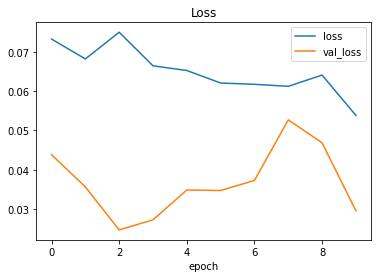

In [180]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(['loss', 'val_loss'])
plt.title("Loss")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

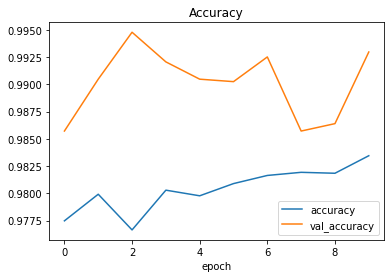

In [181]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(['accuracy', 'val_accuracy'])
plt.title("Accuracy")
plt.xlabel("epoch")

In [182]:
score = model.evaluate(X_test, y_test, verbose = 0)

print("Test Score: ", score[0])
print("Test Accuracy: ", score[1])

Test Score:  0.11632940918207169
Test Accuracy:  0.9773554801940918


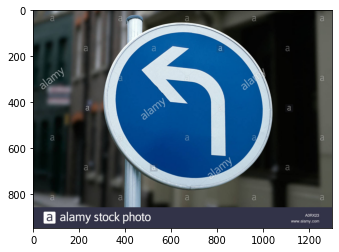

In [183]:
#fetch image
 
import requests
from PIL import Image
url = "https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg"
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)


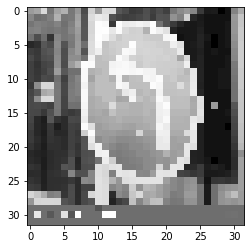

In [184]:
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [185]:
#Reshape reshape
img = img.reshape(1, 32, 32, 1)

In [186]:
#Test image
print("predicted sign: "+ str(np.argmax(model.predict(img), axis=-1)))

predicted sign: [12]
